In [1]:
from sentiment import utils


DATASET_DIR = './goemotions_data/'
classes = utils.load_classes(DATASET_DIR)
classes.remove('neutral')
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise']

In [2]:
%%time
train_df, val_df, test_df = utils.make_dataframes(DATASET_DIR,
                                                  fraction=0.85,
                                                  random=1681944339,
                                                  split_by_class=True,
                                                  drop_neutral=True,
                                                  test_only_singles=True,
                                                  oversample_low=True,
                                                  low_threshold=500)

Random seed: 1682289812


D:\sentiment-analysis\sentiment\utils.py:116: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (df['labels'].str.contains(f'(^|,){label}(,|$)',


CPU times: total: 1.06 s
Wall time: 1.08 s


D:\sentiment-analysis\sentiment\utils.py:568: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


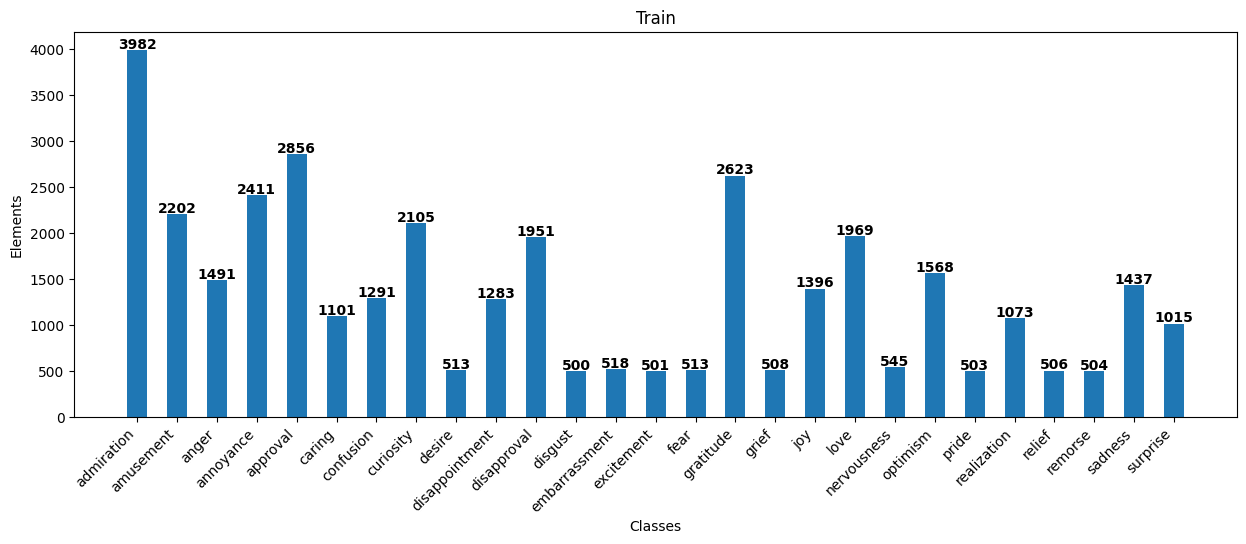

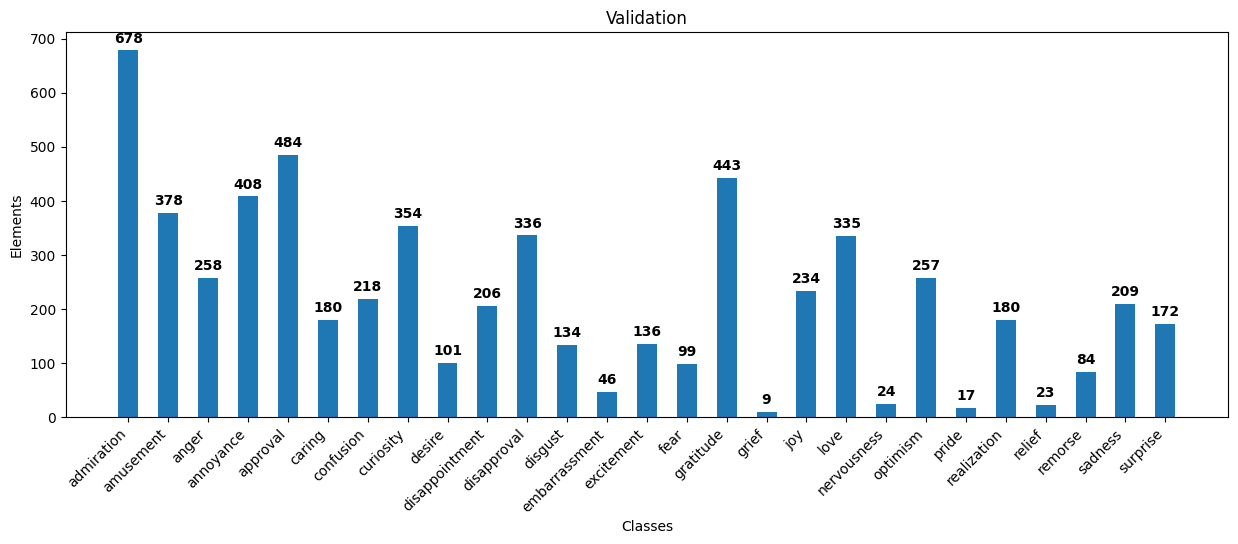

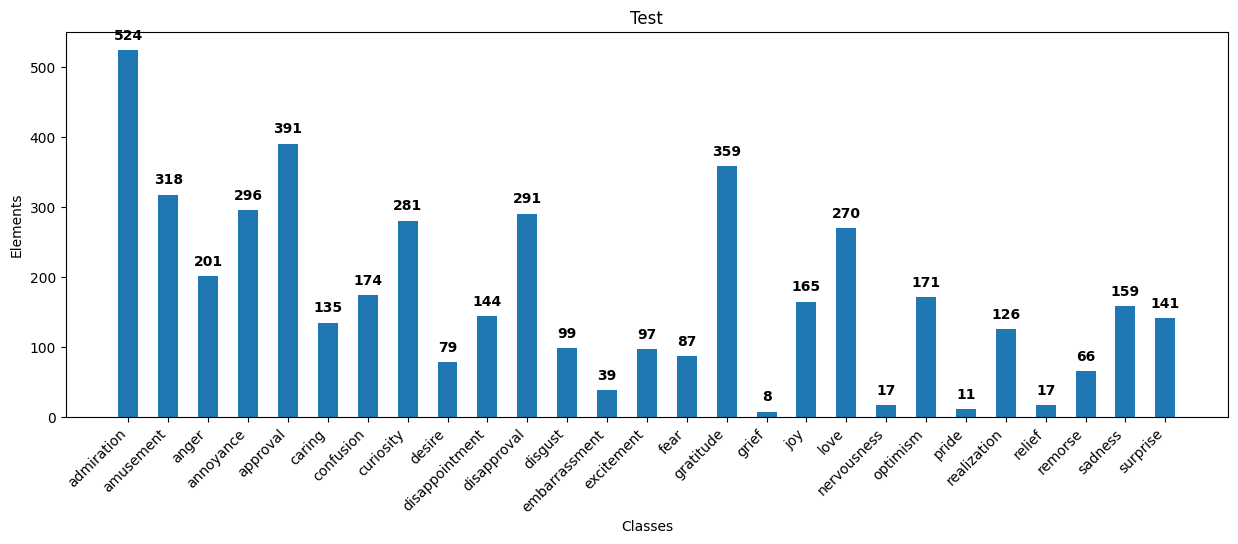

In [3]:
from tensorflow.data import AUTOTUNE

BATCH_SIZE = 64


dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    utils.plot_class_distr(df, classes, title)
train_ds = utils.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = utils.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = utils.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
from sentiment import bert_model

BERT_MODEL = 'small_bert/bert_en_uncased_L-2_H-128_A-2'


model = bert_model.BertSentimentModel(BERT_MODEL, dropout_rate=0.4,
                                      dense_units=256, classes=classes)

In [5]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


THRESHOLD = 0.5
EPOCHS = 10
INIT_LR = 3e-4


optimizer = Adam(INIT_LR)
metrics = utils.create_metrics(classes, THRESHOLD)
loss = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping


history = model.fit(x=train_ds, validation_data=val_ds, epochs=EPOCHS,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
463/463 [==============================] - 661s 1s/step - loss: 0.1980 - precision@0.5/admiration: 0.4685 - recall@0.5/admiration: 0.1567 - precision@0.5/amusement: 0.3035 - recall@0.5/amusement: 0.1094 - precision@0.5/anger: 0.0942 - recall@0.5/anger: 0.0402 - precision@0.5/annoyance: 0.1407 - recall@0.5/annoyance: 0.0195 - precision@0.5/approval: 0.0982 - recall@0.5/approval: 0.0228 - precision@0.5/caring: 0.0417 - recall@0.5/caring: 0.0054 - precision@0.5/confusion: 0.0481 - recall@0.5/confusion: 0.0279 - precision@0.5/curiosity: 0.2527 - recall@0.5/curiosity: 0.1230 - precision@0.5/desire: 0.0211 - recall@0.5/desire: 0.0078 - precision@0.5/disappointment: 0.0482 - recall@0.5/disappointment: 0.0117 - precision@0.5/disapproval: 0.0907 - recall@0.5/disapproval: 0.0261 - precision@0.5/disgust: 0.0229 - recall@0.5/disgust: 0.0260 - precision@0.5/embarrassment: 0.0125 - recall@0.5/embarrassment: 0.0058 - precision@0.5/excitement: 0.0169 - recall@0.5/excitement: 0.0080 - precis

In [7]:
eval_metrics = model.evaluate(x=test_ds, return_dict=True)
utils.print_metrics(eval_metrics)

73/73 [==============================] - 23s 314ms/step - loss: 0.0940 - precision@0.5/admiration: 0.6485 - recall@0.5/admiration: 0.7252 - precision@0.5/amusement: 0.7480 - recall@0.5/amusement: 0.8868 - precision@0.5/anger: 0.5312 - recall@0.5/anger: 0.5075 - precision@0.5/annoyance: 0.3201 - recall@0.5/annoyance: 0.3277 - precision@0.5/approval: 0.4132 - recall@0.5/approval: 0.3836 - precision@0.5/caring: 0.4196 - recall@0.5/caring: 0.3481 - precision@0.5/confusion: 0.4640 - recall@0.5/confusion: 0.3333 - precision@0.5/curiosity: 0.5665 - recall@0.5/curiosity: 0.6975 - precision@0.5/desire: 0.5750 - recall@0.5/desire: 0.2911 - precision@0.5/disappointment: 0.4894 - recall@0.5/disappointment: 0.1597 - precision@0.5/disapproval: 0.4601 - recall@0.5/disapproval: 0.4158 - precision@0.5/disgust: 0.7391 - recall@0.5/disgust: 0.3434 - precision@0.5/embarrassment: 0.5366 - recall@0.5/embarrassment: 0.5641 - precision@0.5/excitement: 0.6364 - recall@0.5/excitement: 0.2165 - precision@0.5/fea

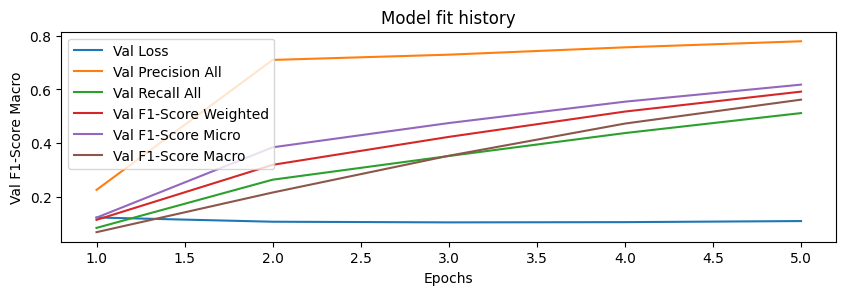

In [8]:
stats = history.history
stats_plots = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
utils.plot_history(stats_plots)

## Score test and run most-important metrics on emotions prediction

In [9]:
from tensorflow.keras.metrics import Precision
from tensorflow_addons.metrics import F1Score


test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(classes), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(), THRESHOLD)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.5869
F1-Score (micro): 0.5740
F1-Score (macro): 0.4889


## Score test and run most-important metrics on sentiments prediction

In [10]:
sentiments = utils.load_sentiments(DATASET_DIR)
sentiment_map = utils.map_sentiments(classes, sentiments)
del sentiment_map[27]
test_metrics = {
    'TP Rate (precision)': Precision(),
    'F1-Score (micro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='micro'),
    'F1-Score (macro)': F1Score(num_classes=len(sentiments), threshold=THRESHOLD, average='macro'),
}
utils.score_test(test_ds, model, test_metrics.values(),
                           THRESHOLD, sentiment_map)
for name, metric in test_metrics.items():
    print('{}: {:.4f}'.format(name, metric.result().numpy()))

TP Rate (precision): 0.8307
F1-Score (micro): 0.7765
F1-Score (macro): 0.7377


In [11]:
utils.test_examples(model, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: 
The war has started: realization 💡
He is desperate in this cruel world: anger 😡 disgust 🤮
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: anger 😡 annoyance 😒
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): admiration 👏 gratitude 🙏
I have the new pan for pancakes.: 
Relax, bro. Take it easy: approval 👍 relief 😅
WTF? Are they kidding us? I'm gonna argue with the manager!: amusement 😂
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: joy 😃
Sorry, I feel bad for having said that: remorse 😔 sadness 😞
Happy birthday, my friend! I wish you a lot of success!: joy 😃
What a shame! I wi

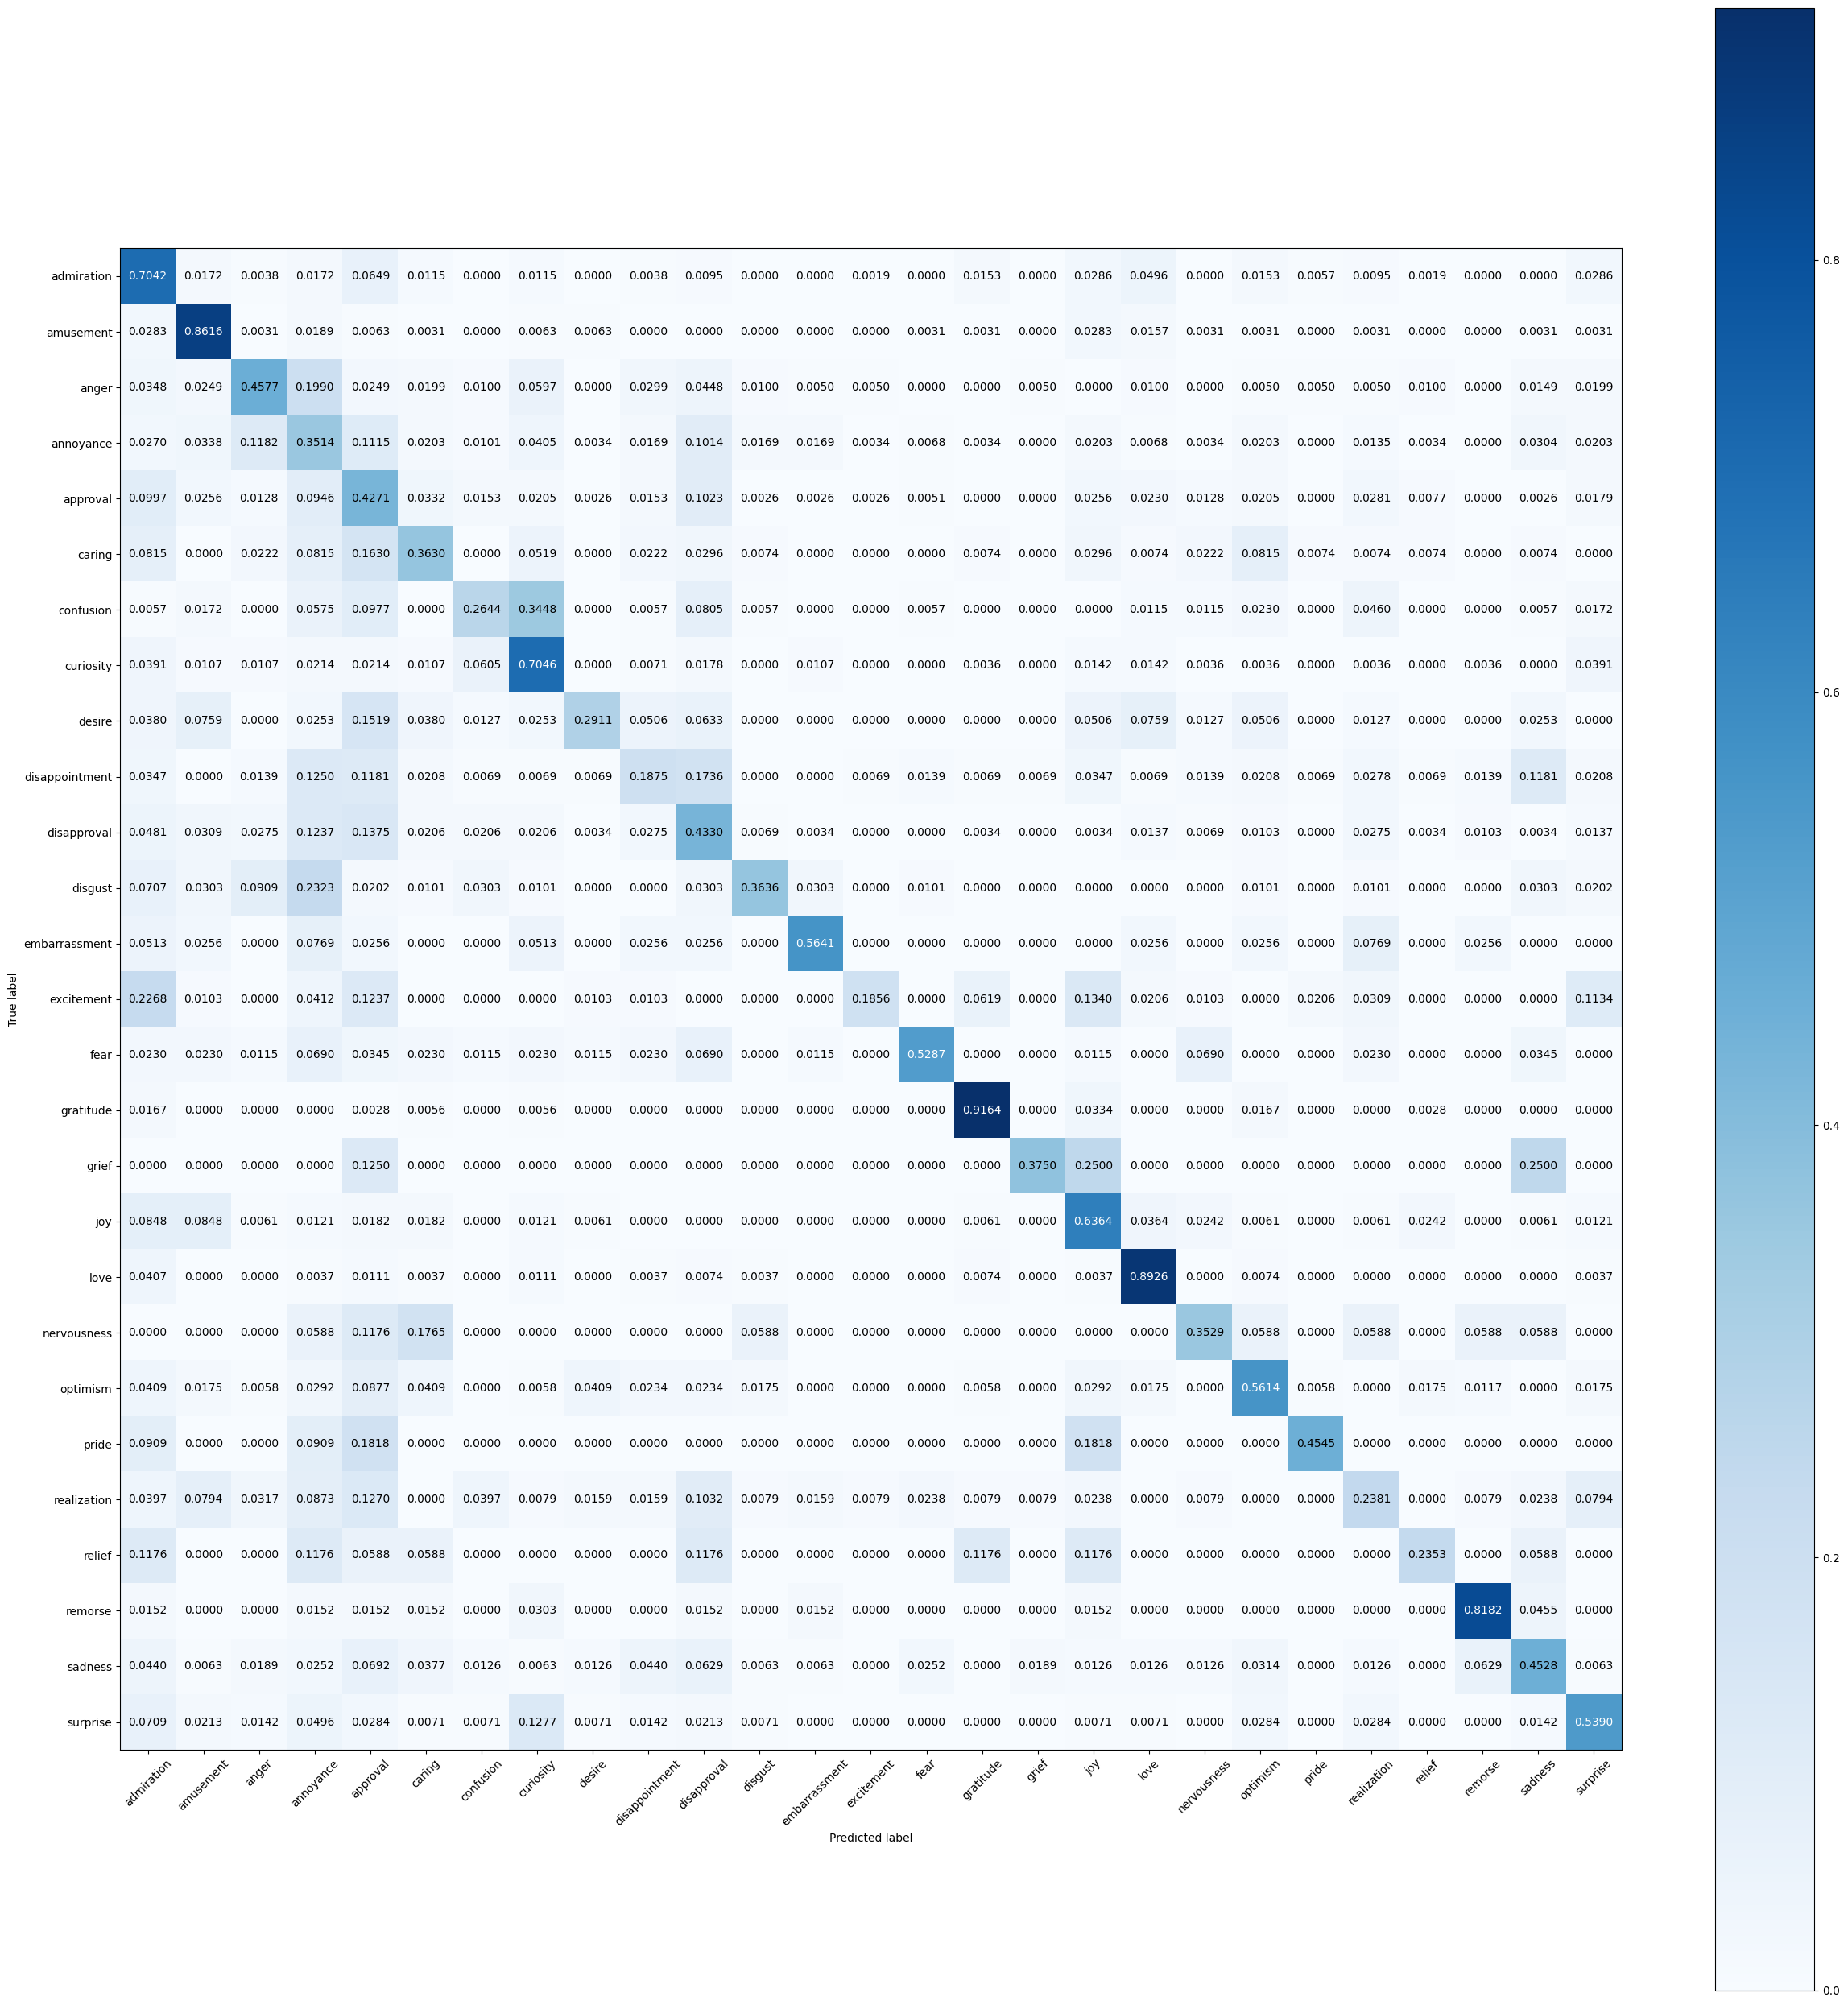

In [12]:
utils.plot_conf_mtrx_all(model, test_ds, classes)

2/2 [==============================] - 1s 125ms/step


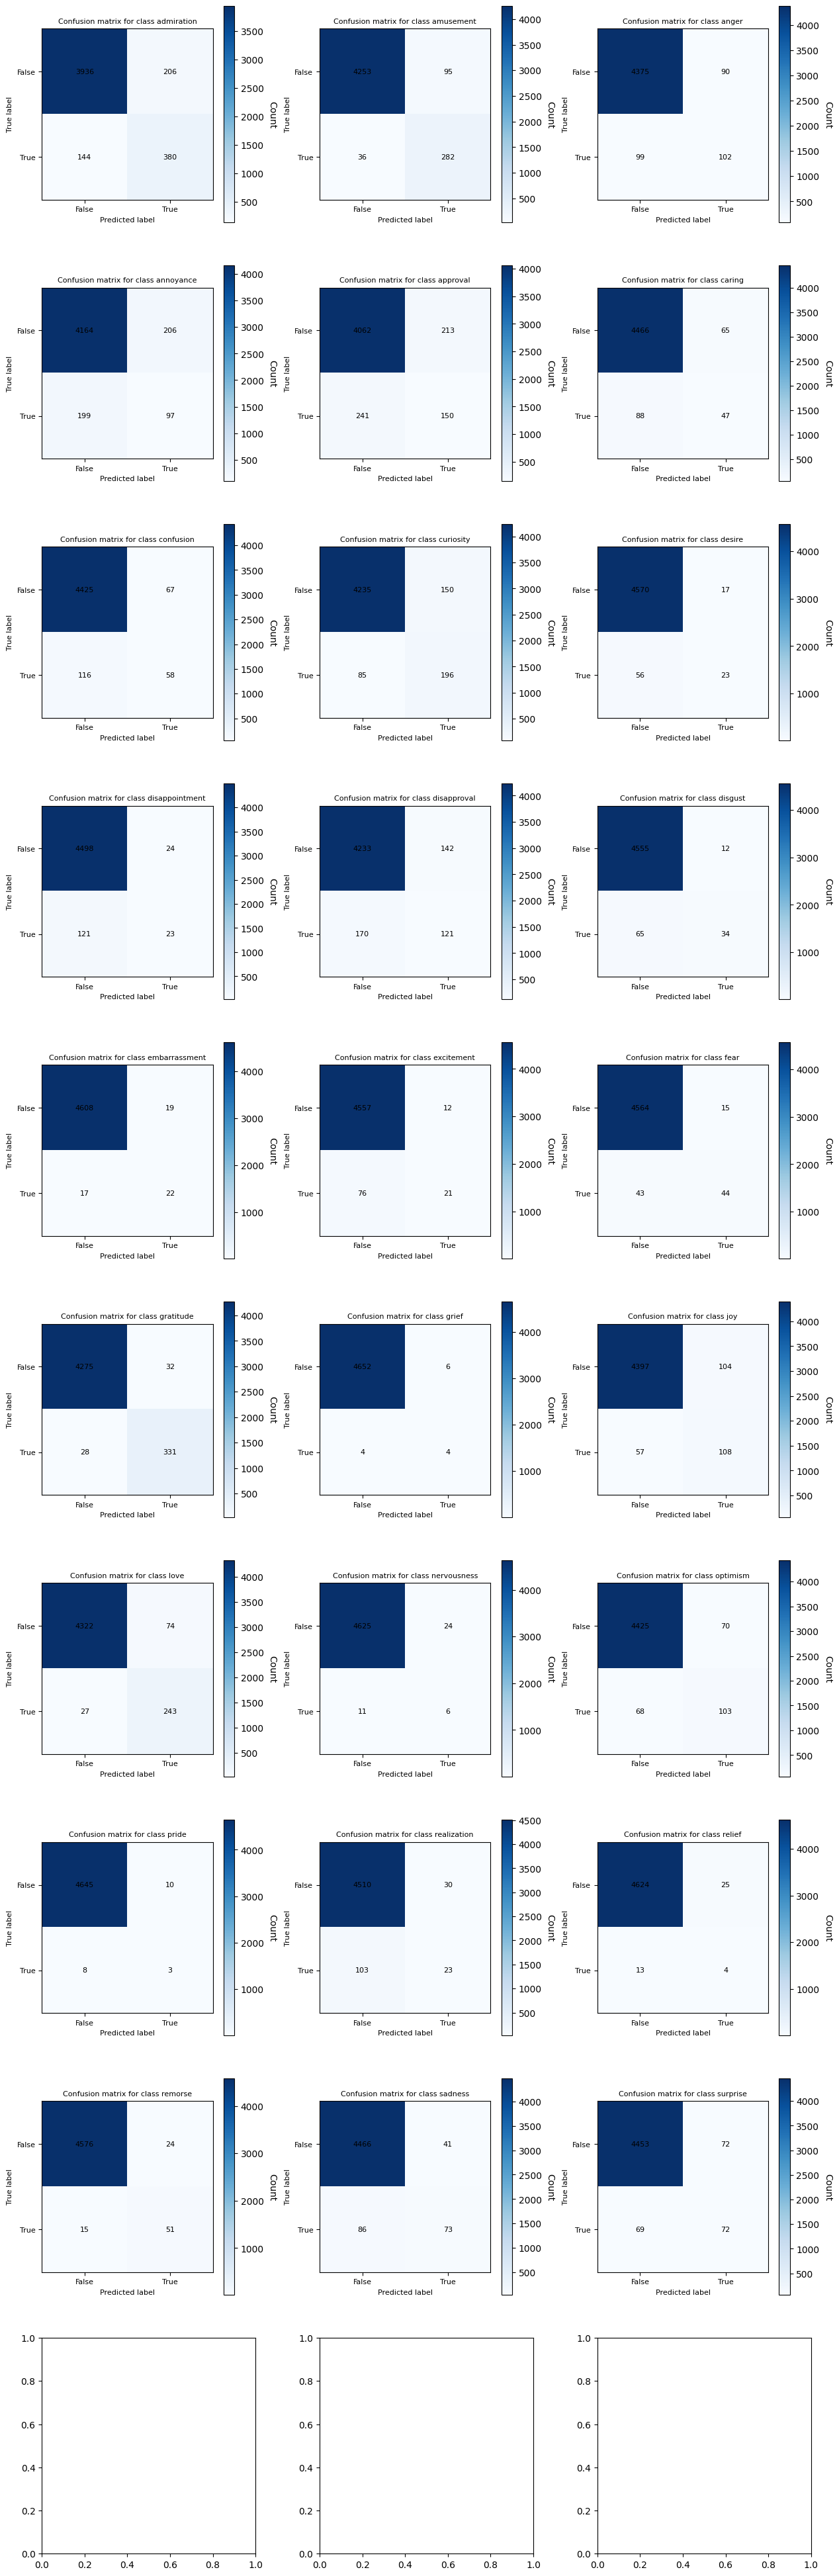

In [13]:
utils.plot_conf_mtrx_per_class(model, test_ds, classes)

In [16]:
model.save_weights('./models/bert_0_7_2_no_neutral')